# CH1. EDA


In [1]:
# 라이브러리 불러오기

%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

import seaborn as sns
import matplotlib.pylab as plt

## 데이터 import

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [3]:
AIRLINE_STATS_CSV = DATA / 'airline_stats.csv'
KC_TAX_CSV = DATA / 'kc_tax.csv.gz'
LC_LOANS_CSV = DATA / 'lc_loans.csv'
AIRPORT_DELAYS_CSV = DATA / 'dfw_airline.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
STATE_CSV = DATA / 'state.csv'

## 1.3.3 예제: 인구에 따른 살인 비율의 위치 추정
### 평균과 절사평균, 중앙값

In [4]:
# 주 별 인구 및 살인 비율을 담고있는 데이터 state.csv
# 상위 10 개만 살펴보기

state = pd.read_csv(STATE_CSV)
print(state.head(10))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE
8      Florida    18801310          5.8           FL
9      Georgia     9687653          5.7           GA


파이썬에서 평균과 중간값을 계산하기 위해 데이터 프레임을 위한 pandas 와 

절사평균 사용을 위해 scipy.stats의 trim_mean 함수를 사용한다.

**절사평균 : 값들을 크기순으로 정렬한 수, 양 끝(가장 크거나 가장 작거나)에서 일정 개수의 값들을 삭제한 뒤 남은 값들을 가지고 구한 평균이다. 극단값의 영향을 제거하기 때문에 선호하는경우가 있다.**

In [5]:
# 인구 평균

state = pd.read_csv(STATE_CSV)
print(state['Population'].mean())

6162876.3


In [6]:
# 인구의 절사 평균

print(trim_mean(state['Population'], 0.1))

4783697.125


In [7]:
# 인구의 중앙값

print(state['Population'].median())

4436369.5


### 가중평균과 가중중간값

가중 평균을 구하기 위해 넘파이를 사용.

가중 중간값을 구하기 위해서는 wquantiles 라는 패키지를 따로 사용.

In [8]:
# 살인 비율

print(state['Murder.Rate'].mean())

4.066


In [9]:
# 인구에 따른 가중치를 준 살인 비율의 평균 

print(np.average(state['Murder.Rate'], weights = state['Population']))

4.445833981123393


In [10]:
# 인구에 따른 가중치를 준 살인 비율의 중간값

print(wquantiles.median(state['Murder.Rate'], weights = state['Population']))

4.4


실제로 그냥 mean 을 구했을 때보다 절사평균을 사용하거나, 인구에 따른 가중치를 준 가중 평균 등을 사용했을 때 본래 중간값과 거의 비슷하게 나오는 것을 볼 수 있었다.

# 변이(variability) 추정

## 주별 인구의 변이 추정값

같은 주별 인구의 변이 추정값을 구해본다. 데이터의 흩어진 정도를 측정하는 과정이다.

> 분산과 표준 편차는 가장 보편적으로 널리 사용되는 변이 측정 방법이다. 이들 모두 특잇값에 민감하다.

> 중간값과 백분위수로부터 평균절대편차와 중간값의 중위절대편차를 구하는 것이 좀 더 로버스트하다.

In [11]:
# 데이터프레임 살펴보기

state.head()

,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ
3,Arkansas,2915918,5.6,AR
4,California,37253956,4.4,CA


### 표준편차

.std()

In [12]:
print(state['Population'].std())

6848235.347401142


### 사분위범위

.quantile(0.75) - .quantile(0.25)

In [13]:
print(state['Population'].quantile(0.75) - state['Population'].quantile(0.25))

4847308.0


### 중위절대편차(MAD: statsmodel의 strong.scale.mad 함수 이용)

표준편차는 MAD의 거의 두 배가 된다. 표준편차는 특잇값에 민감하기 때문에 그럴 수 있다.

(R에서는 기본적으로 MAD의 척도가 평균과 같은 척도를 갖도록 보정된다.)

In [14]:
# 중위절대편차 구하기

print(robust.scale.mad(state['Population']))

3849876.1459979336


아래의 경우 R에서 MAD의 척도가 평균과 같은 척도를 갖도록 보정되는 과정을 그대로 쓴 것이다.

In [15]:
print(abs(state['Population'] - state['Population'].median()).median() / 0.6744897501960817)

3849876.1459979336


# 데이터 분포 탐색하기

위까지 본 것들은 데이터의 위치 혹은 변이를 나타내기 위한 하나의 수치로 데이터를 요약해 보았다.

이와 함께 데이터가 전반적으로 어떻게 분포하고 있는 지를 알아보는 것도 유용하다. (p.38~)

> 박스플롯(boxplot): 데이터의 분포를 시각화하기 위한 간단한 방법으로 튜키가 소개한 그림(box-whisker plot).

> 도수분포표(frequency table): 어떤 구간(interval, bin 등)에 해당하는 수치 데이터 값들의 빈도를 나타내는 기록.

> 히스토그램(histogram): x축에 구간들을, y축에 빈도수를 나타내는 도수 테이블. 시각적으로 비슷하지만 막대 그래프와 히스토그램을 혼동하지 않도록.

> 밀도 그림(density plot): 히스토그램을 부드러운 곡선으로 나타낸 그림. 커널밀도추정(kernel density estimation)을 주로 사용.

## 백분위수와 박스플롯

주별 살인율의 백분위수를 구해본다.

### 백분위수

전체 분포를 알아보는 데에도 백분위수가 유용한데, 주로 사분위수나 십분위수(decile)를 공식적으로 사용한다. 

특히 백분위수는 분포의 tail 부분(외측 범위)을 묘사하는데 적합하다.

In [16]:
state['Murder.Rate'].quantile([0.05, 0.25, 0.5,0.75, 0.95])

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64

In [17]:
# 이렇게만 쓰면 옵션의 기본값으로 0.5 일 때만 나온다.

state['Murder.Rate'].quantile()

4.0

중간값 0.5는 인구의 중간값이 400만명 정도라고 했을 때 살인 비율로, 인구 10만 명당 4건의 살인이 있다는 것을 의미한다.

In [18]:
# 예쁘게 그리기 (원본 주피터노트북 그대로 가져옴)

percentages = [0.05, 0.25, 0.5, 0.75, 0.95]                    # 백분위수 리스트업
df = pd.DataFrame(state['Murder.Rate'].quantile(percentages))
df.index = [f'{p * 100}%' for p in percentages]                # 표형태 만들기
print(df.transpose())                                          # 가로로 보기 위해 행렬을 전치시켰다!

             5.0%  25.0%  50.0%  75.0%  95.0%
Murder.Rate   1.6  2.425    4.0   5.55   6.51


### 박스플롯

주별 인구 분포를 나타내는 박스플롯을 그려보자

<AxesSubplot:>

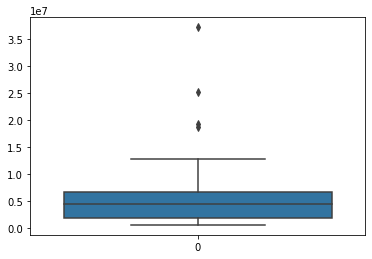

In [19]:
sns.boxplot(data=state['Population'])

너무 못생겼다. 뀨잉뀨잉.

실제로 주어진 코드에서는 이렇게 작성한다.

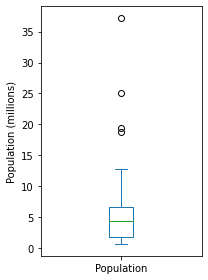

In [20]:
ax = (state['Population']/1_000_000).plot.box(figsize=(3, 4))  # 스케일 조정 및 그래프 사이즈 변경
ax.set_ylabel('Population (millions)')                         # 축 레이블

plt.tight_layout() 
plt.show()

그래프를 보면

중간값이 약 5(500만)에 걸쳐있고 인구수가 극단적으로 높은 특잇값이 바로 있음을 알 수 있다. 기본 설정상 휘스커가 사분위수의 1.5배까지만 표시되도록 되어있다.

실제로 박스플롯에서 outlier로 표현되는 경우는 최댓값 즉 제 3 사분위수 + (사분위범위Q3-Q1)* 1.5 를 더한 위치를 넘어가거나, 최솟값 즉 제 1사분위수 - IQR * 1.5 한 위치에 닿지 않는 값이다.

박스플롯도 다양한 형태가 있다고 한다. 

##### 특잇값의 값이 궁금하니 가져와보자.

### 각 y값을 가져오기(get_ydata())

In [21]:
# 각 값의 y값을 가져와보자 (출처: https://blog.naver.com/faithfuljk/222649208086)

# fig, ax = plt.subplots()

# notch파라미터 True로 하면 중앙값의 95%신뢰 구간을 노치 형태로 표시한다!
box = ax.boxplot(state['Population']/1_000_000, notch = True)

whiskers = [item.get_ydata() for item in box['whiskers']]
print('whiskers:', whiskers)

# 각각 Q1,Q3,max,min 값이 출력된다.

whiskers: [array([1.83300425, 0.563626  ]), array([ 6.68031225, 12.830632  ])]


In [22]:
medians = [item.get_ydata() for item in box['medians']]
print('medians:', medians)

# 중앙값에 대한 정보를 갖는 Line2D 인스턴스의 리스트가 출력된다.

medians: [array([4.4363695, 4.4363695])]


In [23]:
fliers = [item.get_ydata() for item in box['fliers']]
print('fliers:', fliers)

# 수염 범위 밖의 데이터 포인트를 반환한다.
# 만약 인구수 말고도 다른 피처들도 함께 했으면 함께 한 만큼 어레이가 여럿 나올 것이다.

fliers: [array([37.253956, 18.80131 , 19.378102, 25.145561])]


## 도수분포표와 히스토그램
도수분포표는 변수위 범위를 동일한 크기의 구간으로 나눈 다음, 각 구간마다 몇 개의 변수값이 존재하는지 보기 위해 사용된다.

### 도수분포표

도수분포표와 백분위수 모두 구간을 나눠서 데이터를 살펴보는 접근 방법이다.

일반적으로 사분위수와 십분위수는 각 구간에 같은 수의 데이터가 포함되도록, 즉 서로 크기가 다르게 구간을 나누게 된다.

반면에 도수분포표는 구간의 크기가 같도록, 즉 구간 안에 서로 다른 개수의 데이터가 오도록 나누게 된다.

In [24]:
# 주별 인구의 도수분포표 만들기 with cut, value_counts()


"""
pd.cut()은 해당 데이터를 각 구간에 맵핑하는 시리즈를 만든다.
10을 줬기 때문에 10개의 구간으로 나눈다.
"""

population_bin10 = pd.cut(state['Population'], 10)
print(population_bin10.value_counts())

(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: Population, dtype: int64


BinNumber와 States name를 함께 출력하도록 한다.

In [25]:
# Table 1.5 주 별 인구 도수분포표 만들기

population_bin10.name = 'binnedPopulation' 
df = pd.concat([state, population_bin10], axis=1) # 주와 concat함
df = df.sort_values(by='Population') # 인구수 별로 sorting

groups = []
for group, subset in df.groupby(by='binnedPopulation'):
    groups.append({
        'BinRange': group,
        'Count': len(subset),
        'States': ','.join(subset.Abbreviation)
    })
print(pd.DataFrame(groups))

                   BinRange  Count  \
0    (526935.67, 4232659.0]     24   
1    (4232659.0, 7901692.0]     14   
2   (7901692.0, 11570725.0]      6   
3  (11570725.0, 15239758.0]      2   
4  (15239758.0, 18908791.0]      1   
5  (18908791.0, 22577824.0]      1   
6  (22577824.0, 26246857.0]      1   
7  (26246857.0, 29915890.0]      0   
8  (29915890.0, 33584923.0]      0   
9  (33584923.0, 37253956.0]      1   

                                              States  
0  WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N...  
1          KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA  
2                                  VA,NJ,NC,GA,MI,OH  
3                                              PA,IL  
4                                                 FL  
5                                                 NY  
6                                                 TX  
7                                                     
8                                                     
9                              

이를 판다스에 있는 매소드로 히스토그램을 그린다. 

구간 개수를 정의하기 위해 bins를 사용한다.

### 히스토그램

히스토그램은 도수분포표를 시각화하는 방법이다. 

구간의 개수를 정의하기 위해 bins를 설정해준다.

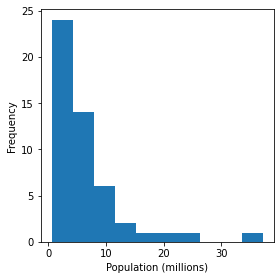

In [26]:
ax = (state['Population'] / 1_000_000).plot.hist(figsize=(4, 4)) # 스케일 조정 및 그래프 사이즈
ax.set_xlabel('Population (millions)') # 축 레이블

plt.tight_layout()
plt.show()

In [27]:
# 여기서 살펴보는 이... df의 모습...
df

,State,Population,Murder.Rate,Abbreviation,binnedPopulation
49,Wyoming,563626,2.7,WY,"(526935.67, 4232659.0]"
44,Vermont,625741,1.6,VT,"(526935.67, 4232659.0]"
33,North Dakota,672591,3.0,ND,"(526935.67, 4232659.0]"
1,Alaska,710231,5.6,AK,"(526935.67, 4232659.0]"
40,South Dakota,814180,2.3,SD,"(526935.67, 4232659.0]"
7,Delaware,897934,5.8,DE,"(526935.67, 4232659.0]"
25,Montana,989415,3.6,MT,"(526935.67, 4232659.0]"
38,Rhode Island,1052567,2.4,RI,"(526935.67, 4232659.0]"
28,New Hampshire,1316470,0.9,NH,"(526935.67, 4232659.0]"
18,Maine,1328361,1.6,ME,"(526935.67, 4232659.0]"


히스토그램은 다음과 같은 정보들을 담고 있다.

- 그래프에 빈 구간들이 있을 수 있다.
- 구간은 동일한 크기를 갖는다.
- 구간의 수(혹은 구간의 크기)는 사용자가 결정할 수 있다.
- 빈 구간이 있지 않은 이상 막대 사이는 공간 없이 서로 붙어있다.

### seaborn 의 displot 으로 히스토그램 그리기

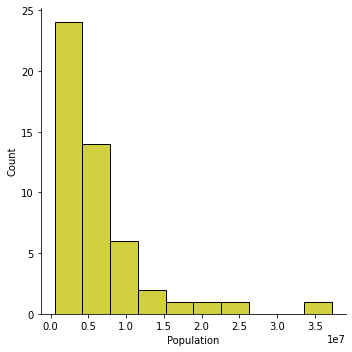

In [28]:
import seaborn as sns

sns.displot(df['Population'], bins = 10, color = 'y')

## 밀도 추정

히스토그램과 관련된 desity plot을 알아보자.

밀도 그림은 데이터의 분포를 연속된 선으로 보여준다. 부드러운 히스토그램으로, kernel density estimation을 통해 데이터로 부터 직접 계산한다.

히스토그램과 가장 큰 차이는 바로 y축 값의 단위이다. 밀도 그림에서는 개수가 아닌 비율(rate)을 표시한다. 

밀도 곡선 아래의 총 면적은 1이고, 구간의 개수 대신 x축의 두 점 사이의 곡선 아래 면적을 계산하며, 이는 두 점 사이에 있는 분포의 비율에 해당한다.


### 주별 살인율 밀도 구하기

.plot.hist() 를 이용하는데, density를 True로 주면 밀도추정곡선이 함께 표시된다. 히스토그램에 겹쳐지게 밀도추정 결과를 표시해본다.

##### xlim은 그래프 내의 x 값 표시 limitation, bins는 1~12의 개수로 구간을 나눈다는 의미이다.

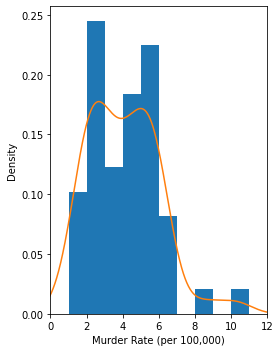

In [31]:
density_plot = state['Murder.Rate'].plot.hist(density = True, xlim = [0,12], bins = range(1,12), figsize = (4,5))
state['Murder.Rate'].plot.density(ax = density_plot)
density_plot.set_xlabel('Murder Rate (per 100,000)')

plt.tight_layout()
plt.show()

### seaborn 의 histplot 으로 밀도추정곡선이 포함된 히스토그램 그리기

<AxesSubplot:xlabel='Murder.Rate', ylabel='Count'>

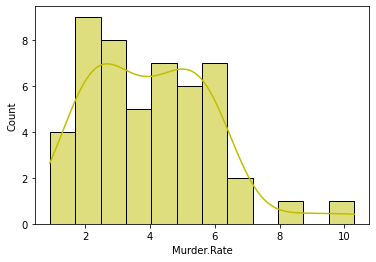

In [32]:
import seaborn as sns

sns.histplot(state['Murder.Rate'], bins = 12, color = 'y', kde = True)

---

> 도수 히스토그램은 y축에 횟수를, x축에 변수 값들을 표시하고 한눈에 데이터의 분포를 볼 수 있다.

> 도수분포표는 히스토그램에 보이는 횟수를 표로 나타낸 것이며,

> 박스플롯에서 박스플롯 위와 아래의 부분은 각각 75%, 25% 백분위수를 말하며, 주로 분포들을 서로 비교하기 위해 사용된다.

> 덴시티 플롯은 히스토그램의 부드러운 곡선 형태로, 개수가 아닌 비율을 보여준다. 추정 방법이 다양하다.
